# **<center>Problema Maximum Cut</center>**

`Prueba de escalado maximo`

**Librerias**

In [2]:
import networkx as nx
import itertools

from dimod import *
import matplotlib.pyplot as plt
import random
import dwave.inspector
from dwave.system import DWaveSampler, LazyFixedEmbeddingComposite

from qubovert import boolean_var

from dwave.system import LeapHybridSampler

**Grafo Max Cut**

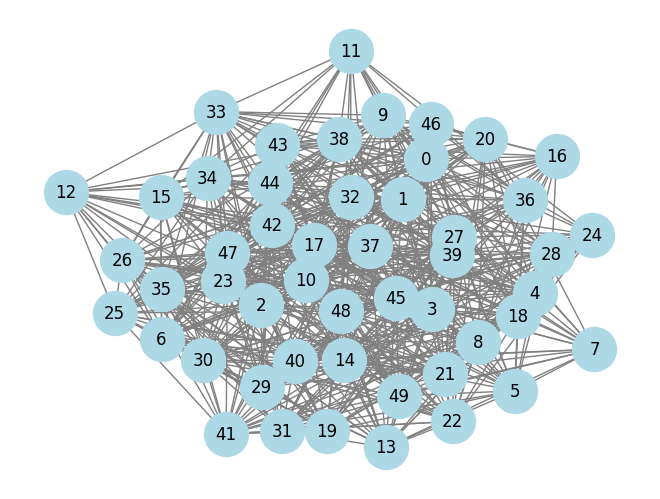

In [3]:
# Numero de nodos

n = 50

# Crea un grafo vacío

G = nx.Graph()
    
# Agrega n nodos al grafo
    
G.add_nodes_from(range(n))
    
# Agrega aristas aleatorias al grafo
    
for i in range(n):
    for j in range(i+1, n):
        if random.random() < 0.5:
            G.add_edge(i, j)
    
# Comprueba si el grafo es conexo

if not nx.is_connected(G):
        
    # Si el grafo no es conexo, intenta agregar más aristas aleatorias
    
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < 0.5:
                G.add_edge(i, j)
                
            # Si el grafo se vuelve conexo, detén el bucle
            
            if nx.is_connected(G):
                break
        else:
            continue
        break
    
    # Devuelve el grafo generado
    
nx.draw(G, with_labels=True, node_size=1000, node_color='lightblue', edge_color='gray')
    

**Función QUBO**

In [4]:
# Creamos una variable binaria por cada nodo de nuestro grafo

x = {n: boolean_var(n) for n in G.nodes}

# Implementamos nuestra función QUBO que no posee restricciones

bqm = sum(-x[i]-x[j]+2*x[i]*x[j] for i,j in G.edges)

# Convertimos el modelo a QUBO 

qubo = bqm.to_qubo()
dwave_qubo = qubo.Q


**Cálculo QPU-Hibrido-Simulado**

In [5]:
# Usamos el simulador que permite D-Wave

#sampleset = SimulatedAnnealingSampler().sample_qubo(dwave_qubo, num_reads=1000)

# Usamos el calculo hibrido clasico-QPU

#sampleset = LeapHybridSampler().sample_qubo(dwave_qubo)

# Realizamos la prueba en un cuantico real para comprobar como el grafo original se embebe en la topologia chimera de D-Wave

sampleset = LazyFixedEmbeddingComposite(DWaveSampler()).sample_qubo(dwave_qubo, num_reads=1000)   

# Obtenemos de igual forma los resultados optimos

solution = sampleset.first.sample
energy = sampleset.first.energy
print(f"numero de aristas: {abs(energy)}")

# La funcionalidad inspector nos permite visualizar como se embebe el grafo en la topologia de nuestra QPU

dwave.inspector.show(sampleset)       

numero de aristas: 372.0


Serving Inspector on http://127.0.0.1:18000/?problemId=88fdf061-9c04-4192-926f-0c733f1602e5

'http://127.0.0.1:18000/?problemId=88fdf061-9c04-4192-926f-0c733f1602e5'

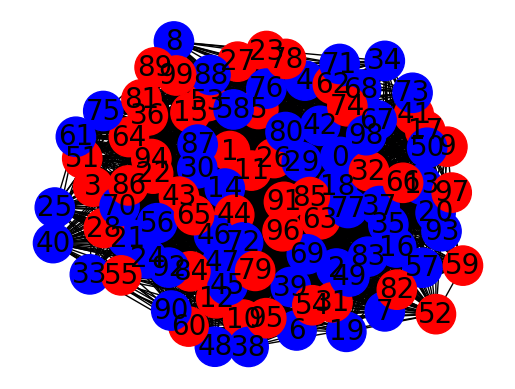

In [66]:
def color_nodes(G, solution):
    # Crear un diccionario que asocie a cada nodo su color
    
    node_color = {node: 'r' if solution[node] == 0 else 'b' for node in G.nodes()}

    # Dibujar el grafo
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_color.values(), node_size=800)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

    plt.axis('off')
    plt.show()


color_nodes(G,solution)

**Cálculo clasico: fuerza bruta**

In [36]:
def max_cut_brute_force(graph):
    """
    Resuelve el problema de Max Cut por fuerza bruta.
    
    Parameters:
        - graph: nx.Graph. El grafo de entrada.
    
    Returns:
        - (cut_size, partition): La tupla con el tamaño del corte máximo encontrado
          y la partición de nodos que lo define.
    """
    nodes = set(graph.nodes())
    max_cut_size = 0
    max_partition = None
    for partition in itertools.chain.from_iterable(itertools.combinations(nodes, r) for r in range(1, len(nodes))):
        A = set(partition)
        B = nodes - A
        cut_size = 0
        for node in A:
            cut_size += len([1 for neighbor in graph.neighbors(node) if neighbor in B])
        if cut_size > max_cut_size:
            max_cut_size = cut_size
            max_partition = (A, B)
    return (max_cut_size)


In [69]:
#max_cut_brute_force(G)

**Cálculo clasico: Espectro maximo**

In [53]:
import networkx as nx
import numpy as np

def max_cut_spectral(G):
    # Crear la matriz de adyacencia y calcular los vectores propios
    A = nx.to_numpy_matrix(G)
    eigvals, eigvecs = np.linalg.eig(A)
    eigvec = np.array(eigvecs[:,1]).reshape(-1)
    
    # Dividir los vértices en dos conjuntos según el vector propio
    partition = {}
    for i, v in enumerate(G.nodes()):
        if eigvec[i] >= 0:
            partition[v] = 0
        else:
            partition[v] = 1
    
    # Contar las aristas que cruzan los conjuntos de vértices
    cut_size = 0
    for i, j in G.edges():
        if partition[i] != partition[j]:
            cut_size += 1
    
    return cut_size


In [67]:
max_cut_spectral(G)

1404